In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tools.sm_exceptions import ValueWarning
from matplotlib import pyplot
from pmdarima import auto_arima
from tqdm import tqdm
import warnings

#in practice do not supress these warnings, they carry important information about the status of your model
warnings.filterwarnings('ignore', category=ValueWarning)

### Preparing the dataset for the time serie analysis

In [46]:
tickerSymbol = 'AAPL'
data= pd.read_csv('data/AAPL.csv')
data_daily= pd.read_csv('data/AAPL_daily.csv')
data_weekly= pd.read_csv('data/AAPL_weekly.csv')
data_monthly= pd.read_csv('data/AAPL_monthly.csv')
df = pd.DataFrame(data)
df_day = pd.DataFrame(data_daily)
df_week = pd.DataFrame(data_weekly)
df_mon = pd.DataFrame(data_monthly)
dfs = [df_day, df_week, df_mon]
for df in dfs:
    print(df.dtypes)

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object
Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object
Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object


In [47]:
for df in dfs:
    print(df.isna().sum())

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [48]:
for i, df in enumerate(dfs):
    print(dfs[i])
    dfs[i] = dfs[i].rename(columns={"Date": "date", "Close": "close", 'Open':'open', 'High':'highest', 'Low':'lowest','Volume':'volume'})
    dfs[i]['returns'] = ((dfs[i]['close'] - dfs[i]['open']) / dfs[i]['open']) * 100
    dfs[i]['date_'] = dfs[i]['date']
    dfs[i].set_index("date_", inplace=True)

            Date       Open       High        Low      Close  Adj Close  \
0     2008-02-01   4.865714   4.878214   4.720714   4.776786   4.071817   
1     2008-02-04   4.793214   4.853571   4.693571   4.701786   4.007886   
2     2008-02-05   4.658214   4.785714   4.603571   4.620000   3.938171   
3     2008-02-06   4.672500   4.711429   4.348929   4.357143   3.714106   
4     2008-02-07   4.284643   4.456429   4.188214   4.330000   3.690970   
...          ...        ...        ...        ...        ...        ...   
3066  2020-04-07  67.699997  67.925003  64.750000  64.857498  63.690235   
3067  2020-04-08  65.684998  66.842499  65.307503  66.517502  65.320358   
3068  2020-04-09  67.175003  67.517502  66.175003  66.997498  65.791725   
3069  2020-04-13  67.077499  68.425003  66.457497  68.312500  67.083061   
3070  2020-04-14  70.000000  72.062500  69.512497  71.762497  70.470955   

          Volume  
0     1010744000  
1      899234000  
2     1141042000  
3     1573272400  
4   

In [49]:
for df in dfs:
    print(df.describe())

              open      highest       lowest        close    Adj Close  \
count  3071.000000  3071.000000  3071.000000  3071.000000  3071.000000   
mean     25.073663    25.319095    24.831513    25.085161    23.213939   
std      16.788261    16.971821    16.640988    16.820934    16.666973   
min       2.835357     2.928571     2.792857     2.792857     2.380681   
25%      11.955714    12.028393    11.849822    11.947143    10.183958   
50%      22.321428    22.547501    22.096430    22.296785    19.256674   
75%      35.310000    35.452501    35.076251    35.246251    33.128231   
max      81.184998    81.962502    80.837502    81.800003    80.327812   

             volume      returns  
count  3.071000e+03  3071.000000  
mean   3.782496e+08     0.021805  
std    3.285542e+08     1.587396  
min    4.544800e+07   -12.004678  
25%    1.351788e+08    -0.764913  
50%    2.767912e+08     0.053264  
75%    5.017710e+08     0.839450  
max    2.622057e+09    12.952174  
             open 

### Checking the stationary of the data: stock value

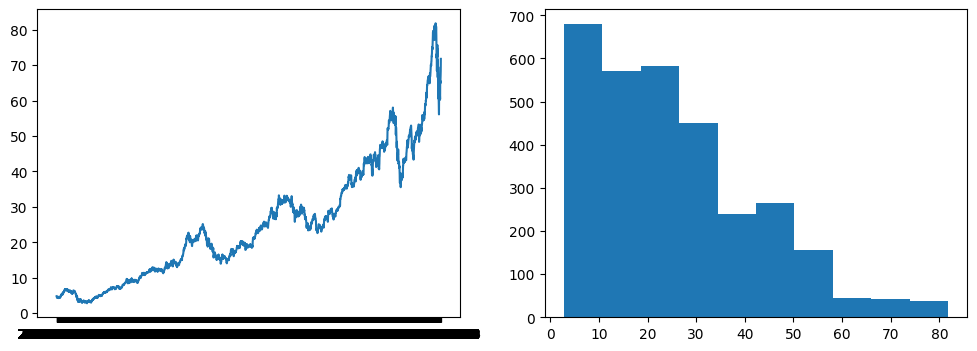

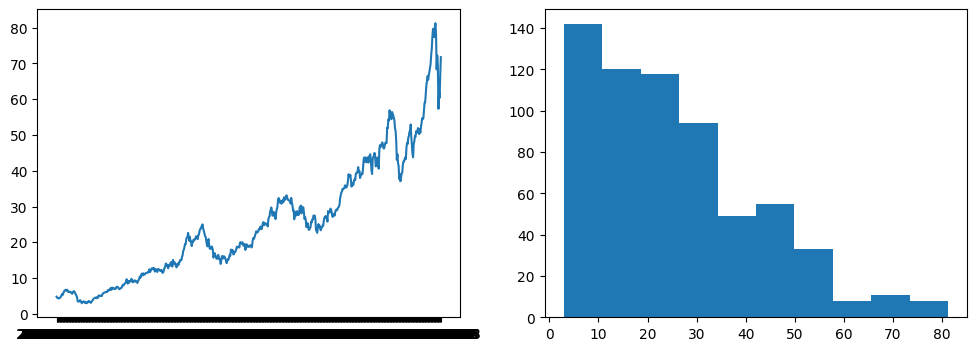

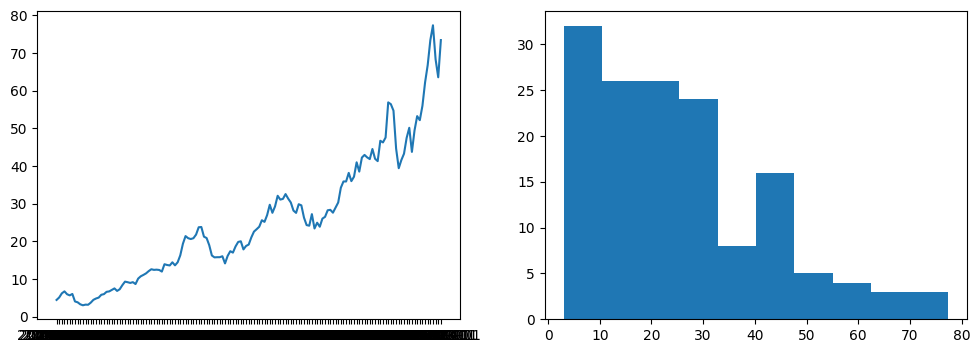

In [50]:
for i, df in enumerate(dfs):
    y =  dfs[i]['close']
    f = plt.figure(figsize=(12,4))
    ax = f.add_subplot(121)
    ax2 = f.add_subplot(122)
    ax.plot(y)
    ax2.hist(y)


In [51]:
#spliting the data into 5 chunks
y = dfs[0]['close'][:3000]
chunks = np.split(dfs[0]['close'][:3000], indices_or_sections=10)
print(np.mean(chunks, axis=1))
print(np.var(chunks, axis=1))

[ 4.65089287  6.81743214 11.42382739 18.77895837 17.29391308 24.55688331
 28.22148333 31.34281658 45.4204418  51.13039999]
[ 1.61354091  2.20370937  1.99643786 14.06341094  3.15312112 17.14661286
  8.5963908  23.53547735 27.31237868 71.78572087]


c:\Users\killi\Documents\Projects\Financial-Forecasting-with-Timeseries\env_name\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


#### Observation:

There appears to be a trend in the data. The p-value will confirm if weather or not the data is stationary.

In [52]:
from statsmodels.tsa.stattools import adfuller

adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(y)

In [53]:
print(pvalue)

0.9971534577050603


#### Conclusion:

We fail to reject the null hypothesis, meaning the dataset is non-stationary if we work with closing prices. However, there is another approach which consists in computing the returns which are supposed to be normally distributed around 0.

#### Analyzing the correlogram

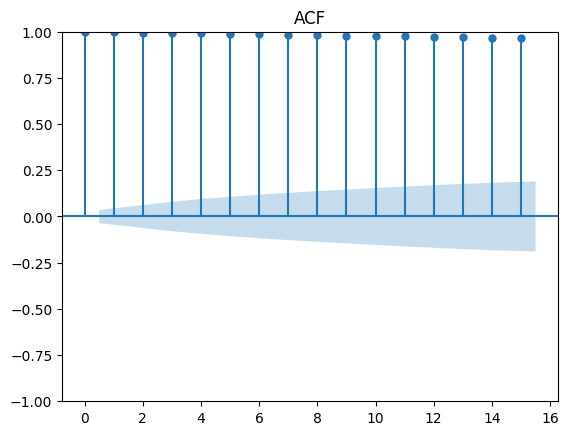

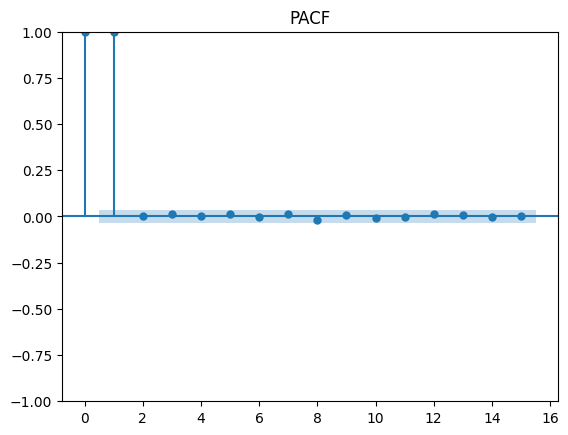

In [54]:
#Autocorrelation
acf_plot = plot_acf(y, lags=15, title='ACF')
#Partial Auto-correlation
pacf_plot = plot_pacf(y, lags=15, title='PACF')

#### Observation:

The autocorrelations are positive for many number of lags (10), so the series needs further differencing. The stock return (difference between opening and closing stock price) might provide the mean to reach stationarity.

### Building a forecasting ARIMA model

The ARMA models combines the AR models and the MA models. The ARMA(p,q) contains the AR(p) and the MA(q) and can be used for univariate time series.

The main assumption in time series analysis is that the time series is stationary and this is not the case for many pratical situations. The solution to this can be found in the Autoregressive Integrated Moving Average(ARIMA) model. The ARIMA (p,d,q) introduces the possibility to apply differencing to the data d times in order to make it stationary. After the differenciation, the model becomes ARMA(p,q).

ARIMA is a natural extension to the class of ARMA models — they can reduce a non-stationary series to a stationary series using a sequence of differences.

ARIMA model has 3 parameters:

P — Auto regressive feature of the model (number of lags of Y to be used as predictors)

D — Differencing order (minimum number of differencing needed to make the series stationary)

Q — Moving average feature of the model (number of lagged forecast errors that should go into the ARIMA Model)


#### Finding the order of differencing (d)

The purpose of differencing it to make the time series stationary. Let's start with a first order of differencing.

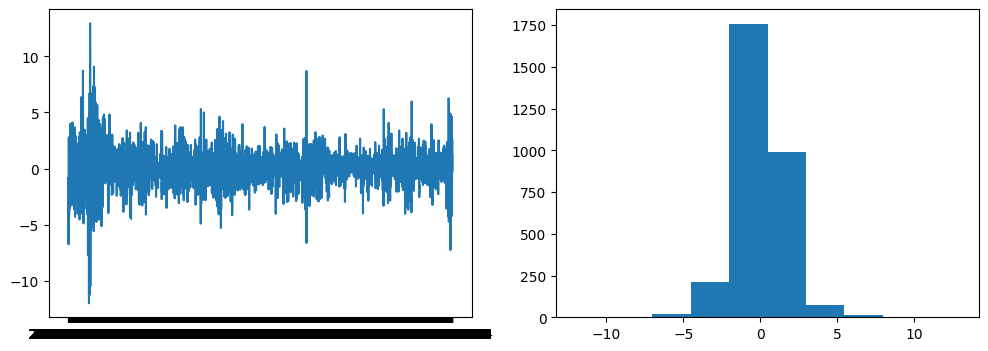

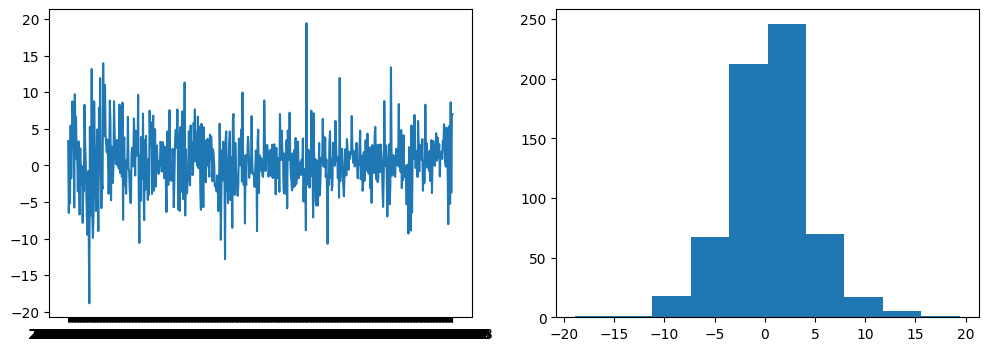

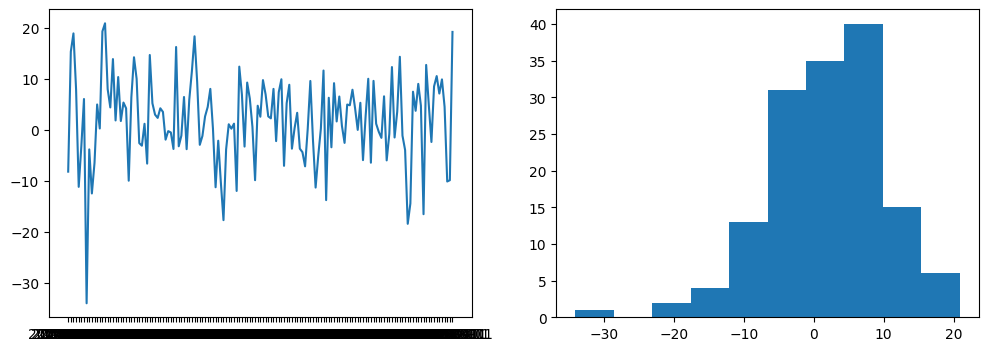

In [55]:
for i, df in enumerate(dfs):
    y =  dfs[i]['returns']
    f = plt.figure(figsize=(12,4))
    ax = f.add_subplot(121)
    ax2 = f.add_subplot(122)
    ax.plot(y)
    ax2.hist(y)


#### Observation:

the data seems to be distributed around a mean of 0 which could mean it is stationary. The p-value will confirm it:

In [56]:
#spliting the data into 5 chunks
y = dfs[0]['returns'][:3000]
chunks = np.split(dfs[0]['close'][:3000], indices_or_sections=10)
print(np.mean(chunks, axis=1))
print(np.var(chunks, axis=1))

[ 4.65089287  6.81743214 11.42382739 18.77895837 17.29391308 24.55688331
 28.22148333 31.34281658 45.4204418  51.13039999]
[ 1.61354091  2.20370937  1.99643786 14.06341094  3.15312112 17.14661286
  8.5963908  23.53547735 27.31237868 71.78572087]


c:\Users\killi\Documents\Projects\Financial-Forecasting-with-Timeseries\env_name\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


In [57]:
from statsmodels.tsa.stattools import adfuller
adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(y)

In [58]:
print(pvalue)

1.0684229735312661e-29


#### Conclusion:

P_value < 0.05, so we reject the null hypothesis, meaning the dataset is stationary if we work with stock returns.

### Analyzing the correlogram

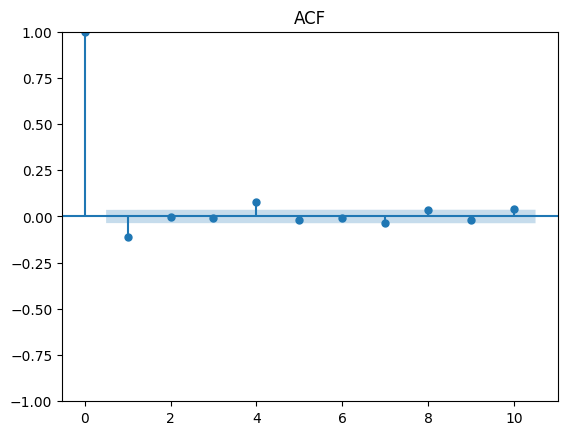

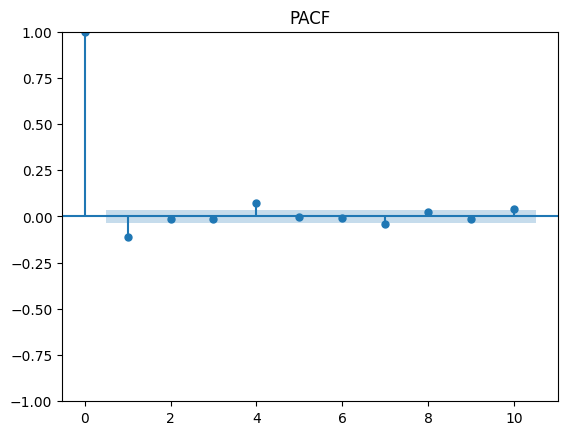

In [59]:
#Autocorrelation
acf_plot = plot_acf(y, lags=10, title='ACF')
#Partial Auto-correlation
pacf_plot = plot_pacf(y, lags=10, title='PACF')

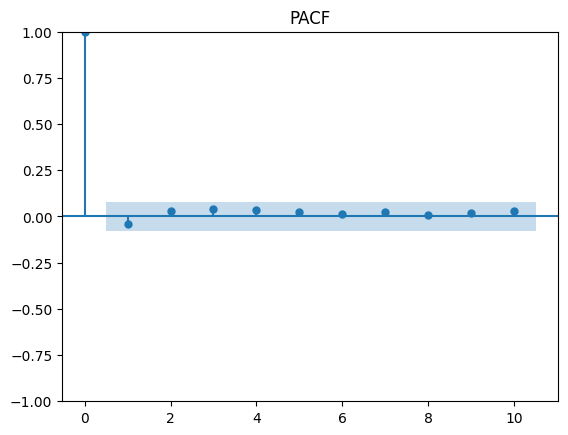

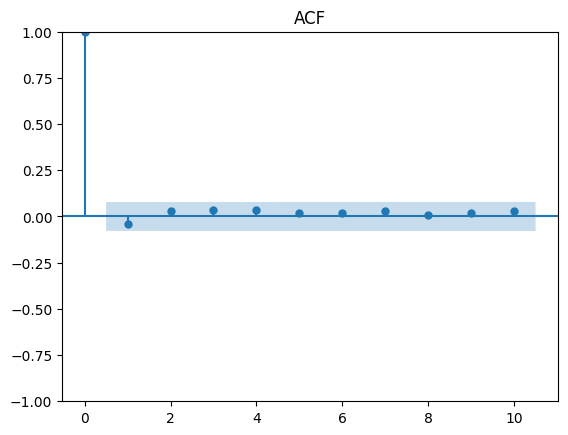

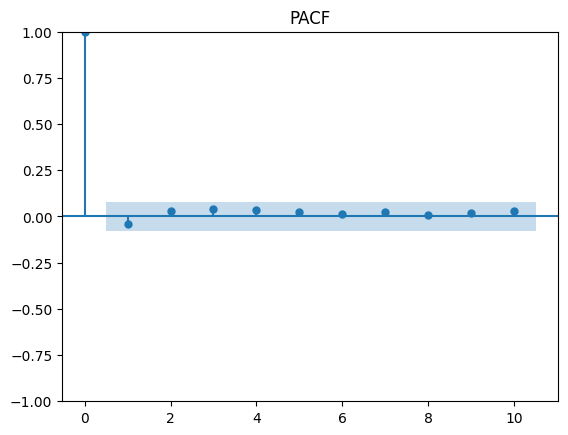

In [60]:
y = dfs[1]['returns'][:630]
#Autocorrelation
plot_acf(y, lags=10, title='ACF')
#Partial Auto-correlation
plot_pacf(y, lags=10, title='PACF')

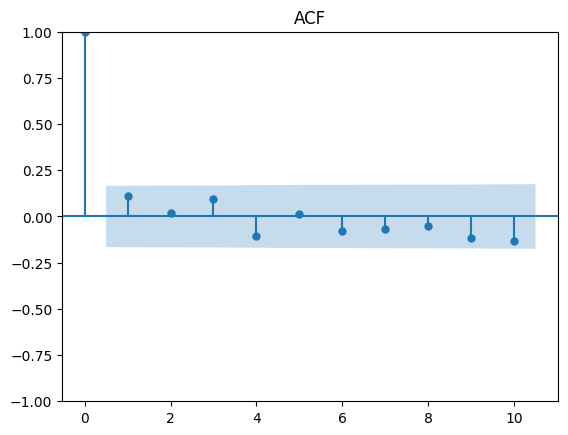

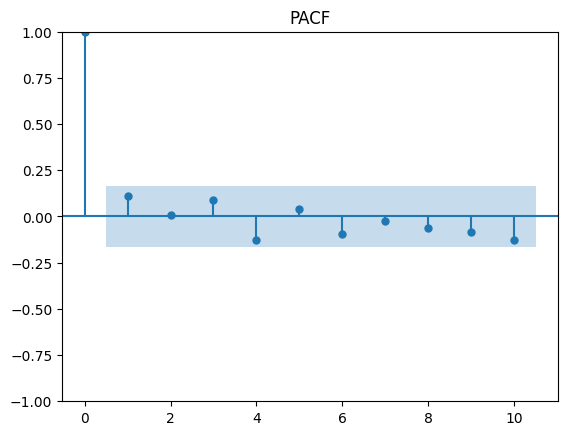

In [61]:
y = dfs[2]['returns'][:140]
#Autocorrelation
plot_acf(y, lags=10, title='ACF')
#Partial Auto-correlation
acf_plot = plot_pacf(y, lags=10, title='PACF')

#### Observation:

Firstly, we notice than smoothing the signal by taking a weekly or monthly timescale does not help in improving the correlograms. Then we notice that the ACF and the PACF cut off at lag 1. We also notice that on lag 4, we have a strong signal on the PACF (representing the AR part of an ARMA model) which could be due to the fact that the stock market is open 5 days a week. The first order differencing seems to have made the data stationary.

#### Finding the AR term (p)

The next step is to identify if the model needs any AR terms. You can find out the required number of AR terms by inspecting the Partial Autocorrelation (PACF) plot. The PACF plot has a significant spike at lag 1 and 4, meaning that all the higher-order autocorrelations are effectively explained by these lags. We will be conservative and take a p = 1 to start with and then compute again with a p = 4.

#### Finding the MA term (q)

To find this parameter, we can simply take a look at the ACF for the number of MA terms. The ACF tells how many MA terms are required to remove any autocorrelation in the stationarized series. The ACF cuts off at lag 1 and 4, so we will take q = 1 and then q = 4.

#### Building the ARIMA models

In [62]:
# Function that calls ARIMA model to fit and forecast the data
def StartARIMAForecasting(Actual, P, D, Q):
    model = ARIMA(Actual, order=(P, D, Q))
    model_fit = model.fit()
    prediction = model_fit.forecast()
    print('Model parameters = %s' % (list(model_fit.params)))
    print(model_fit.summary())
    return prediction

#### ARIMA (1,1,1)

In [ ]:
y = dfs[0]['close'][:3000]
nb_elements = len(y)
#Use 70% of data as training, rest 30% to Test model
TrainingSize = int(nb_elements * 0.7)
TrainingData = y[0:TrainingSize]
TestData = y[TrainingSize:nb_elements]

#new arrays to store actual and predictions
Actual = [x for x in TrainingData]
Test = [x for x in TestData]
Predictions = list()

#in a for loop, predict values using ARIMA model
for timepoint in range(len(Test)):
    ActualValue =  Test[timepoint]
    #forcast value
    Prediction = StartARIMAForecasting(Actual, 1,1,1)
    print('Actual=%f, Predicted=%f' % (ActualValue, Prediction))
    print('')
    #add it in the list
    Predictions.append(Prediction)
    print(Prediction)
    Actual.append(ActualValue)
    

0.45218318813729164
0.45474672848268216
Test Mean Absolute percentage error: 0.010


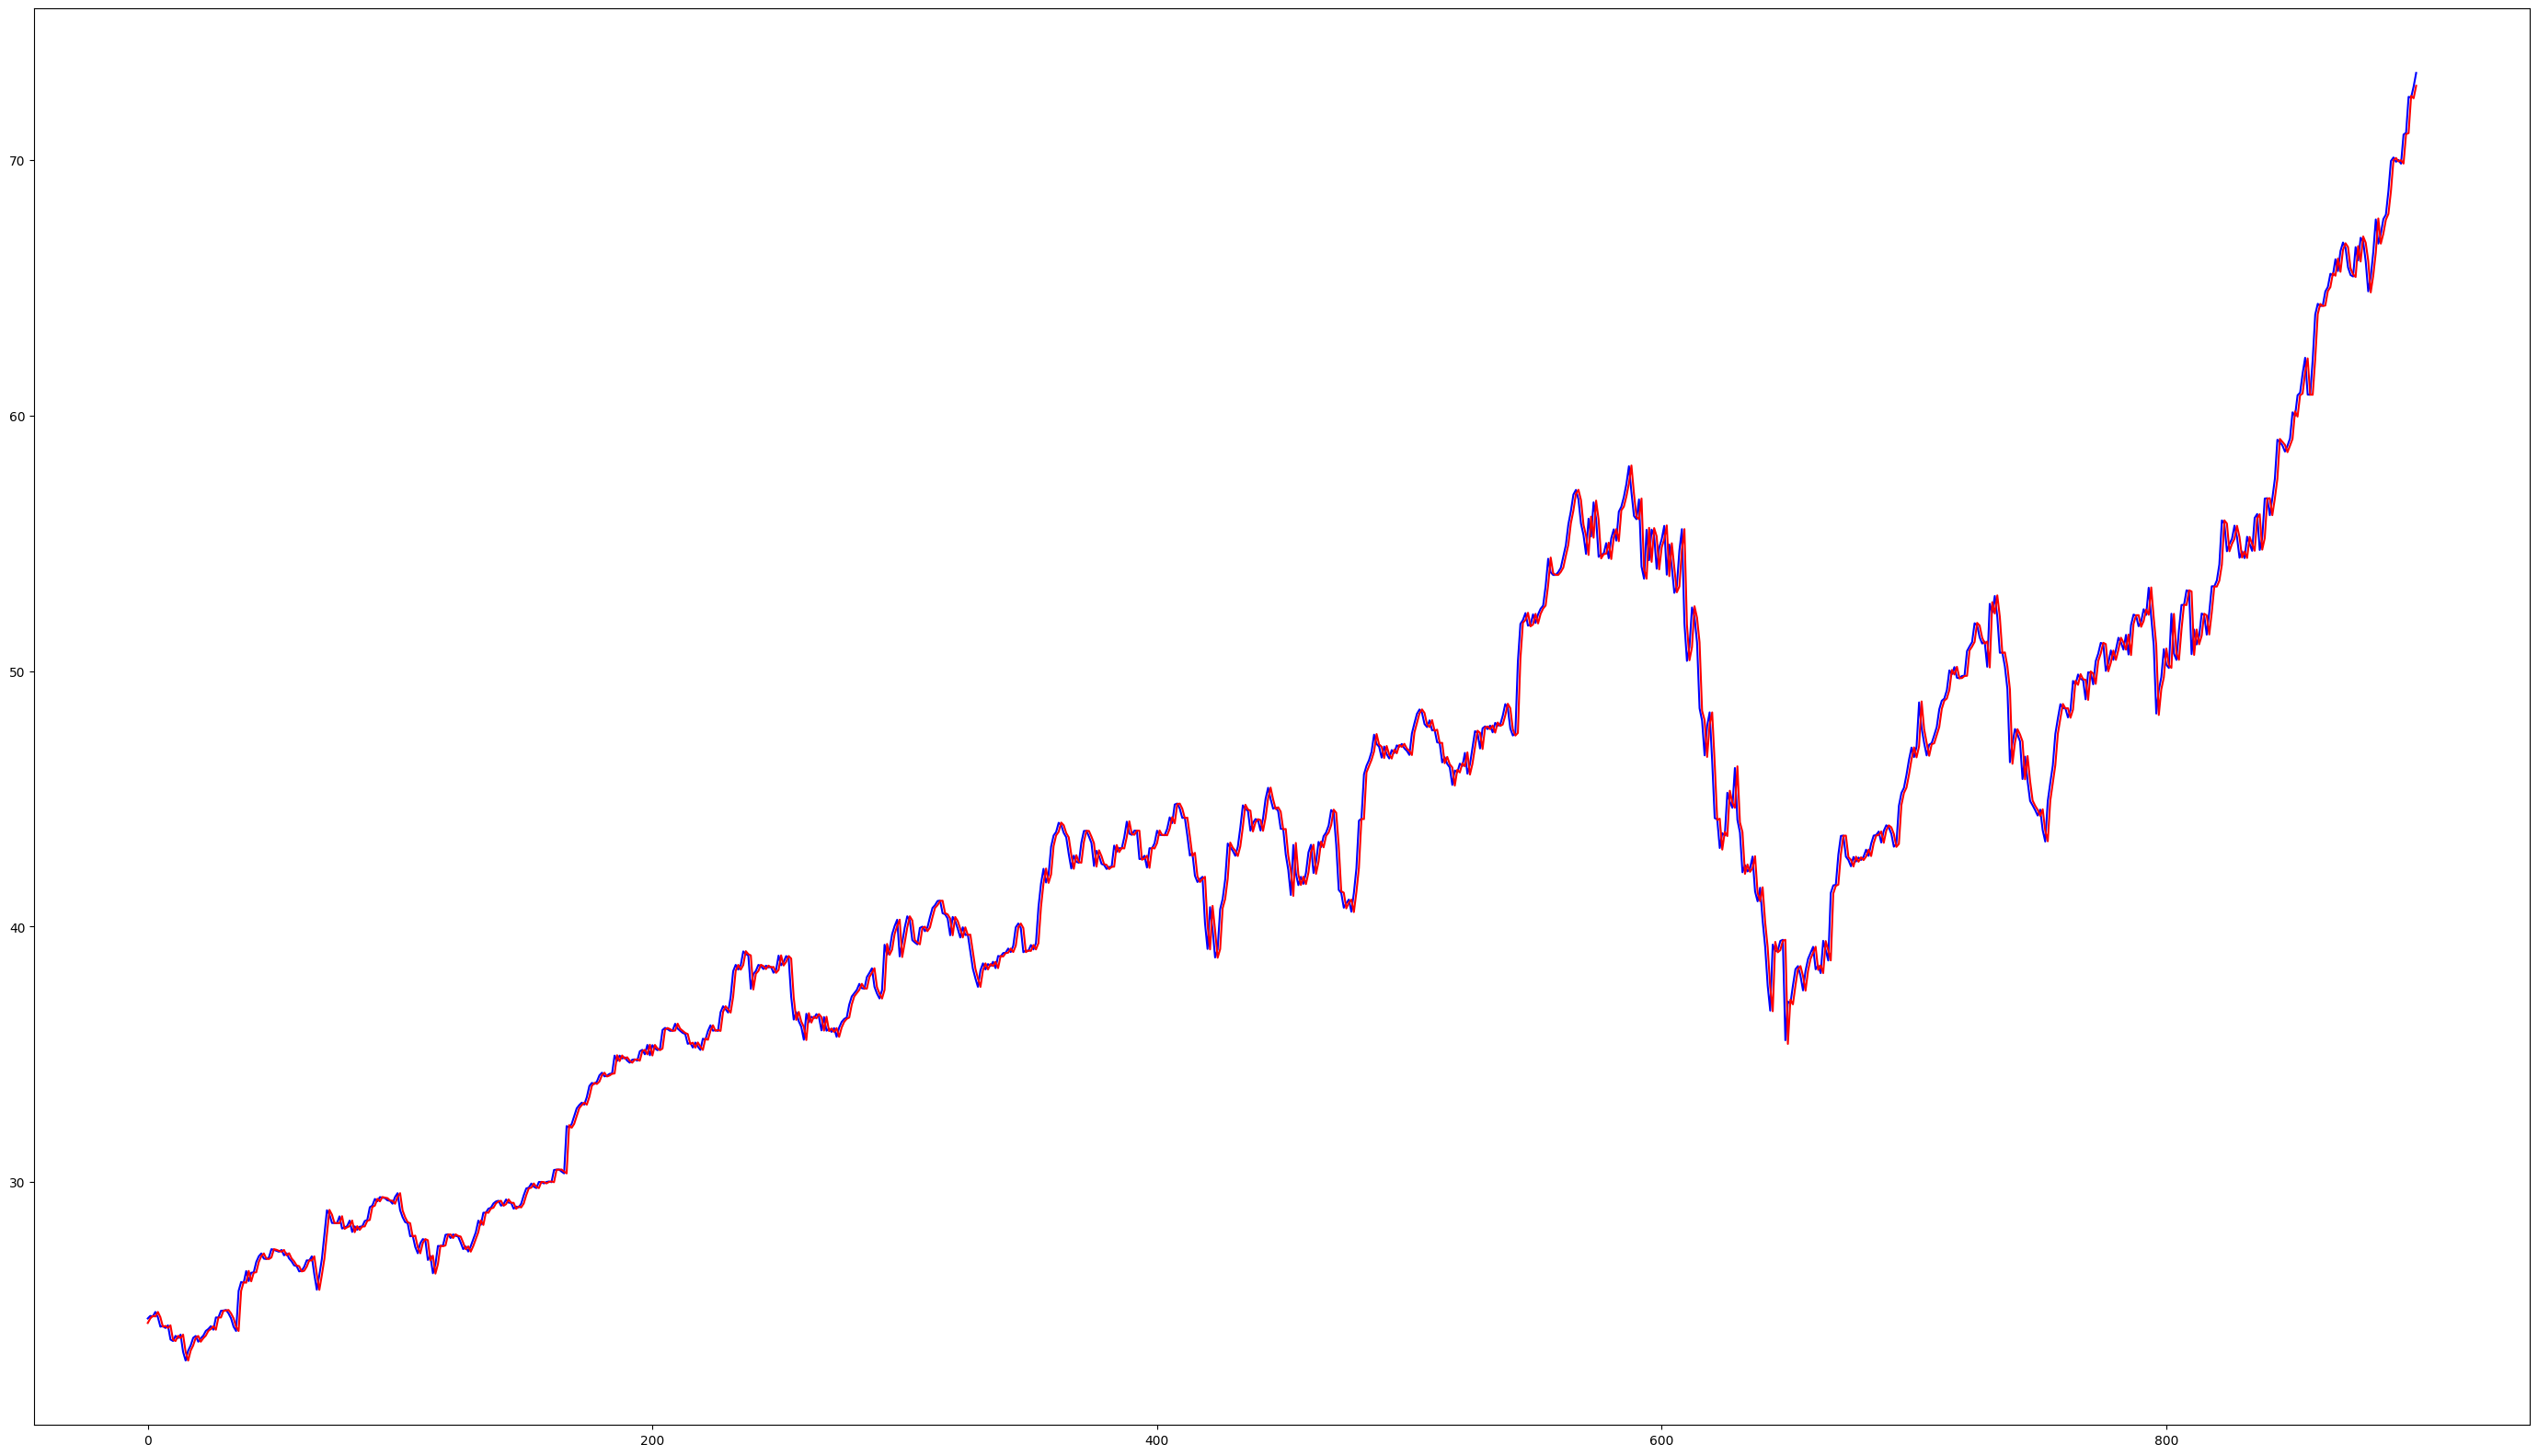

In [64]:
#Print MSE to see how good the model is
from sklearn.metrics import mean_squared_error, mean_absolute_error

print(mean_squared_error(Test,Predictions))
print(mean_absolute_error(Test,Predictions))
Error = mean_absolute_percentage_error(Test, Predictions)
print('Test Mean Absolute percentage error: %.3f' % Error)
# plot
#pyplot.plot(y)
pyplot.figure(figsize=(35,20))
pyplot.plot(Test, color='blue')
pyplot.plot(Predictions, color='red')
pyplot.show()

#### ARIMA (4,1,4)

In [ ]:
y = dfs[0]['close'][:3000]
nb_elements = len(y)
#Use 70% of data as training, rest 30% to Test model
TrainingSize = int(nb_elements * 0.7)
TrainingData = y[0:TrainingSize]
TestData = y[TrainingSize:nb_elements]

#new arrays to store actual and predictions
Actual = [x for x in TrainingData]
Test = [x for x in TestData]
Predictions = list()

#in a for loop, predict values using ARIMA model
for timepoint in range(len(Test)):
    ActualValue =  Test[timepoint]
    #forcast value
    Prediction = StartARIMAForecasting(Actual, 4,1,4)
    print('Actual=%f, Predicted=%f' % (ActualValue, Prediction))
    print('')
    #add it in the list
    Predictions.append(Prediction)
    print(Prediction)
    Actual.append(ActualValue),

0.4529222871976794
0.45707155949428463
Test Mean Absolute percentage error : 0.010


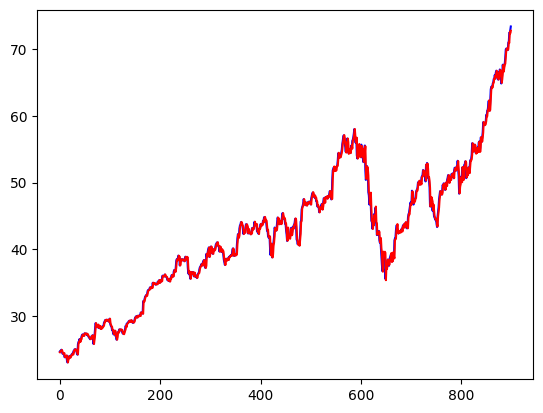

In [66]:
#Print MSE to see how good the model is
Error = mean_absolute_percentage_error(Test, Predictions)
from sklearn.metrics import mean_squared_error, mean_absolute_error
print(mean_squared_error(Test,Predictions))
print(mean_absolute_error(Test,Predictions))
print('Test Mean Absolute percentage error : %.3f' % Error)
# plot
#pyplot.plot(y)
pyplot.plot(Test, color='blue')
pyplot.plot(Predictions, color='red')
pyplot.show()

#### Observation:

The ARIMA (1,1,1) found previously seems to produce good predictive results with no lag in the signal. All coefficients are over the significance threshold and the MSE is very low. As for the ARIMA(4,1,4), the results are quite similar but the computing cost is much higher.

#### Conclusion:

So, we seem to have a decent ARIMA model. But is that the best? We need to dig further to draw relevant conclusions that is to predict the future. In the next section, a bot will be trained to take decisions based on the ARIMA's (1,1,1) predicted return values, to buy or sell stock shares with hope to make a profit ! we will also try a simpler model AR(1).

#### Auto ARIMA forecast Python function

In [67]:
y = dfs[0]['close'][:3000]

model = auto_arima(y, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=4, max_q=4, # maximum p and q
                      m=1,              # frequency of series
                      d=1,              # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3665.185, Time=0.47 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3663.899, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3665.509, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3665.467, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3669.806, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.829 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3000
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1829.949
Date:                Sat, 19 Oct 2024   AIC                           3663.899
Time:                        13:47:56   BIC                           3675.911
Sample:                             0   HQIC                          3668.220
                               - 3000                                       

#### Observation:

The AIC scores are very close from one model to another though the function did not exceed an order of 1.

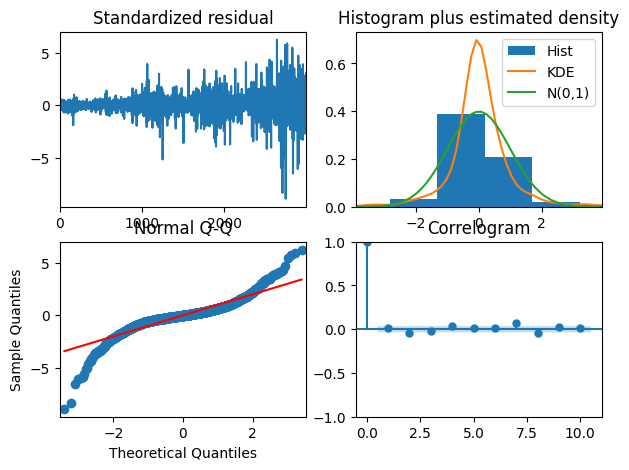

In [68]:
model.plot_diagnostics(figsize=(7,5))
plt.show()

#### Observation:

The correlogram of residuals is flat which is ideal meaning that the residual erros are not autocorrelated (residuals in a time serie is what is left over after fitting a model). The density plot suggest normal distribution with mean zero. Overall, this model seems like a good fit. Let's move on to the next step, setting up the stock bot and comparing its financial performance based on different ARIMA / AR models.



#### Setting up the bot

In [69]:
def run_simulation(returns, prices, amt, order, n, m, thresh, verbose=False, plot=True):
    if type(order) == float:
        thresh = None
    curr_holding = False
    events_list = []
    predictions = []
    init_amt = amt

    #go through dates
    for date, r in tqdm (returns.iloc[3000:].items(), total=len(returns.iloc[3000:])):
        #if you're currently holding the stock, sell it
        if curr_holding:
            sell_price = prices.loc[date]
            curr_holding=False
            ret = (sell_price-buy_price)/buy_price
            amt *= (1+ret)
            events_list.append(('s', date, ret))

            if verbose:
                print('Sold at $%s'%sell_price)
                print('Predicted Return: %s'%round(pred,4))
                print('Actual Return: %s'%(round(ret, 4)))
                print('=======================================')
            continue

        #get data til just before current date
        curr_data = prices[:date].to_numpy()
        curr_data = [x for x in curr_data]
        if type(order) == tuple:
            try:
                #fit model
                model = ARIMA(curr_data, order=(n,1,m))
                model_fit = model.fit()
                #get forecast
                pred = model_fit.forecast()
                yhat = pred[0]
                predictions.append(yhat)
            except:
                pred = thresh - 1
                predictions.append(pred)
        #if you predict a high enough return and not holding, buy stock
        if (not curr_holding) and \
                ((type(order) == float and np.random.random() < order)
                 or (type(order) == tuple and pred > thresh)
                 or (order == 'last' and curr_data[-1] > 0)):

            curr_holding = True
            buy_price = prices.loc[date]
            events_list.append(('b', date))
            if verbose:
                print('Bought at $%s'%buy_price)

    if verbose:
        print('Total Amount: $%s'%round(amt,2))

    #graph
    if plot:

        plt.figure(figsize=(10,4))
        plt.plot(prices[3000:])
        plt.xticks(np.arange(0, len(prices[3000:]), step=10), rotation=30)

        y_lims = (int(prices.min()*.95), int(prices.max()*1.05))
        shaded_y_lims = int(prices.min()*.5), int(prices.max()*1.5)

        for idx, event in enumerate(events_list):
            plt.axvline(event[1], color='k', linestyle='--', alpha=0.4)
            if event[0] == 's':
                color = 'green' if event[2] > 0 else 'red'
                plt.fill_betweenx(range(*shaded_y_lims),
                                  event[1], events_list[idx-1][1], color=color, alpha=0.1)

        tot_return = round(3000*(amt / init_amt - 1), 2)
        tot_return = str(tot_return) + '%'
        plt.title("%s Price Data\nThresh=%s\nTotal Amt: $%s\nTotal Return: %s"%(tickerSymbol, thresh, round(amt,2), tot_return), fontsize=20)
        plt.ylim(*y_lims)
        plt.show()

    return amt


#### Model 1: Random buying

The model will be computed several times and the average financial performance will be assessed.

In [70]:
final_avg_perf = [run_simulation(dfs[0]['returns'], dfs[0]['close'], 100, 0.5, None, 0, 0, verbose=False, plot=False) for _ in range(0,200)]

100%|██████████| 71/71 [00:00<00:00, 15721.44it/s]


Text(0.5, 1.0, 'Avg: $98.16\nSD: $18.97')

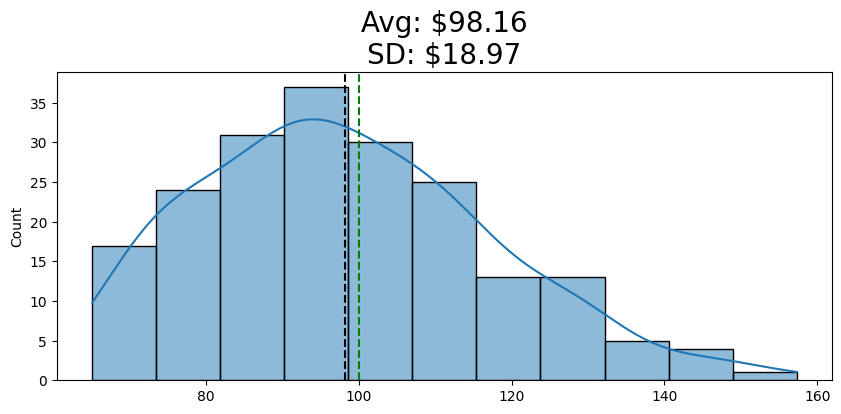

In [71]:
plt.figure(figsize=(10,4))
sns.histplot(final_avg_perf,kde=True)
plt.axvline(np.mean(final_avg_perf), color='k', linestyle='--')
plt.axvline(100, color='g', linestyle='--')
plt.title('Avg: $%s\nSD: $%s'%(round(np.mean(final_avg_perf),2), round(np.std(final_avg_perf),2)), fontsize=20)

Observation:

The bot didn't do well with a random buying model. In fact, we lost money of our initial investment of 100 dollars. In addition, the high variability (SD of 20) represents too much risk from a business perspective.

Model 2: ARIMA(1,1,1)

100%|██████████| 71/71 [00:05<00:00, 12.44it/s]


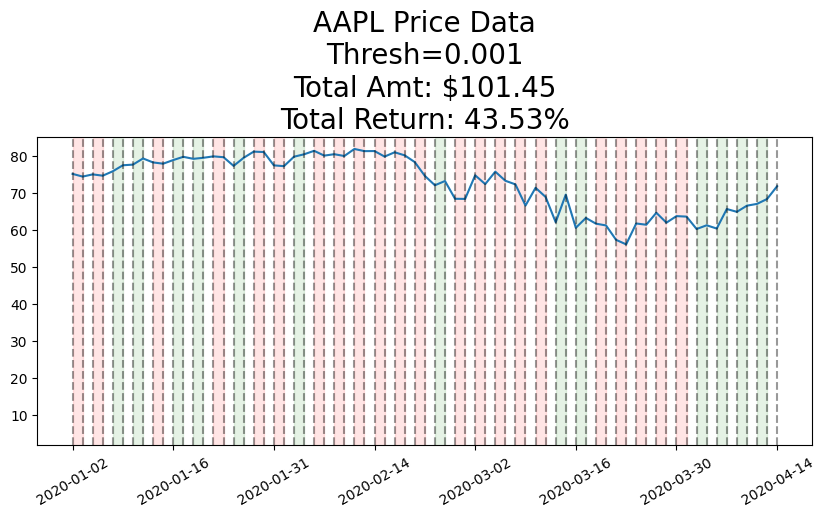

101.45097609862214

In [72]:
run_simulation(dfs[0]['returns'], dfs[0]['close'], 100, (1,1,1), 1, 1, 0.001, verbose=False, plot=True)

#### Observation:

Success ! We managed to make a profit of our initial investment. The model seems to produce good results. However, this is cruelly misleading as any unexpected variations in the signal (such as covid) would severally impede the model's performance.